In [1]:
import tensorflow as tf
#tf.enable_eager_execution()#这东西还必须在最开始就执行，放后面都不行
tf.executing_eagerly()

True

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers



In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
#@param {type:"string"}
#在这里，我们直接down下来mobilenet_v2（一个已经训练好的模型）


# 建立model

In [4]:
IMAGE_SHAPE = (224, 224)

#将下载下来的模型作为keras的一个layer，封装在classifier之中。
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))#tuple的链接(tuple1)+(tuple2)
])
# 该图层包装可调用对象以用作Keras图层。可调用对象可以直接传递，
# 也可以由带有传递给的句柄的Python字符串指定hub.load()。



这里我们把hub封装为一个keras的layer中，可以和其他layer组合。  
在这里我们建立的model叫做classifier，即这个model只有一层，就是hub层

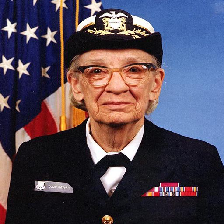

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
#single image
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper



In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])#model.predict(input)
result.shape
#因为是单个图片，而网络是要处理大量图片的，单个图片对于大量图片的维度而言，少了一个维度。
#mat[np.newaxis,...]增加一个维度,在这里增加的是第一维度。

(1, 1001)

result的结果是1001个逻辑结果组成的vector

In [8]:
#获得最大的值对应的index
predicted_class = np.argmax(result[0], axis=-1)
        #axis=0,按列，axis=1，按行，向下是第一维度，向右是第二维度
        #如果axis = 0，则它将是第一个维度，如果axis = -1，则它将是最后一个维度。
        #axis=num，其中num指的是第几维度，-num表示倒数。
predicted_class


653

## Decode（解码）

In [9]:
##把预测的结果，转变成实际意义的label名称
##把txt变成np.array


#download the label
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

#将txt->load->string->list->np.array
imagenet_labels = np.array(open(labels_path).read().splitlines())


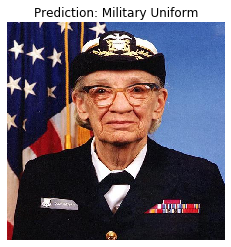

In [10]:
plt.imshow(grace_hopper)
    #imshow就可以把matrix变成图片
plt.axis('off')
    
predicted_class_name = imagenet_labels[predicted_class]
    #label是以np.ndarray的格式存放的
_ = plt.title("Prediction: " + predicted_class_name.title())

# transfer learning

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


### 批量处理图片  (preprocessing.image.ImageDataGenerator)

In [12]:
## normalize+变换一下图片的size。
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
        ##批量处理image的方法（旋转，裁剪，翻转等的图片批量处理的方法）
        #rescale（num）像素标准化！所有像素矩阵直接*num后
image_data = image_generator.flow_from_directory(str(data_root), 
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=32,  #iterator的最小单元是batch，这也是为什么用for循环，
                                                                 #每次拿出的是一个batch
                                                 shuffle=True,   #在load的时候，把所有image都shuffle。
                                                )
                        #直接调用generator的时候，并不会执行。


#flow_from_directory, 指的明输入的位置，以str的形式,


#flow方法用于对已经读入内存的图片数据执行处理，flow_from_directory对文件夹下的数据执行预处理，
#flow适用于小数据集、flow_from_directory适用于大的数据集。
#这两个处理方法都无限循环生成预处理后的batch数据，
#flom_from_directory 迭代器
#实际在类定义和方法调用时只是定义预处理的功能，在网络训练时才会真正生成batch数据，并且用一个生成一个。


Found 3670 images belonging to 5 classes.


In [13]:
type(image_data)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [14]:
                                     #### tutorial  ####
#image_generator=tf.keras.preprocessing.image.ImageDataGenerator
#image_generator.flow_from_directory

print(type(image_data))        # DirectoryIterator class的
print(image_data.target_size)  # each image size
print(image_data.shuffle)      # 判定数据是否已经被shuffle过了
print(image_data.class_mode)   # categorical- one hot
print(image_data.num_classes)  # data中class的个数
print(image_data.samples)      
print(image_data.batch_size)
print(image_data.class_indices.items())
print(image_data.class_mode)
print(image_data.classes.shape)
print(np.unique(image_data.classes))
print(type(image_data.class_indices))



                                  ###   generator   ####

#generator是一种迭代器，该种迭代器会每次被调用的时候，执行到一个逻辑yeild，并且可以连续接连的调用，而不是每次重新调用。
#这种generator在被直接调用的时候是不会执行的，只有生成器函数调用generator的时候，才会执行，返回一个数，并记下执行到那里了，
#当再次被调用的时候，就会接着继续执行下一个迭代的结果。


<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
(224, 224)
True
categorical
5
3670
32
dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])
categorical
(3670,)
[0 1 2 3 4]
<class 'dict'>


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

##这就是一个generator的调用，generator在for循环之下，被调用，每次调用都会返回一个yeild值。

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


## Run the classifier on a batch of image

In [16]:
result_batch = classifier.predict(image_batch)
#返回的是label对应预测相对概率

In [17]:
result_batch.shape

#a batch有32个图片。

(32, 1001)

In [18]:
predicted_class_name = imagenet_labels[np.argmax(result_batch,axis=-1)]
#predict出来的是以label为index，以相对概率为value的np.array
#需要把predict的对应概率最大值的index找到，才是其预测的label。
predicted_class_name

array(['daisy', 'daisy', 'daisy', 'bee', 'pot', "jack-o'-lantern",
       'comic book', 'picket fence', 'honeycomb', 'daisy', 'daisy',
       'daisy', 'cardoon', 'face powder', 'coral fungus', 'cup',
       'picket fence', 'cardoon', 'porcupine', 'coral fungus', 'vault',
       'picket fence', 'daisy', 'daisy', 'sea urchin', 'daisy', 'bee',
       'bow', 'dough', 'bee', 'daisy', 'daisy'], dtype='<U30')

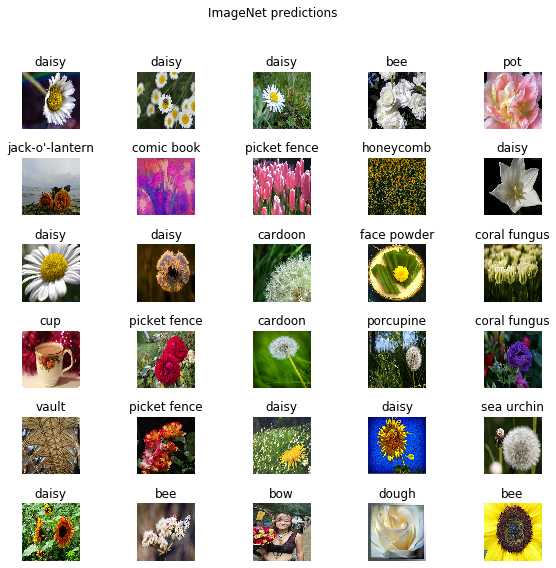

In [19]:
#画图
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

这是用完全不同的神经网络去预测毫不相关的内容。
可以看到，预测的结果很差很差。  

因此这里我们需要加个顶层神经网络，只训练顶层神经网络和已有神经网络之间的关联，完成迁移学习（本来学的是分辨猫和狗，我们加个帽子，只训练帽子，就会分辨花的种类了）

## Download headless model

In [20]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 
#@param {type:"string"}
#这是个字符串


In [21]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))#input的维度是一个image的维度。

#keraslayer的obj是字符串类型的地址，可以是本地的也可以是URL（网页的）

In [22]:
type(feature_extractor_layer)

tensorflow_hub.keras_layer.KerasLayer

In [23]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
#image_batch还是一批花的image
#返回的是32个维度为1280的vector
#下一层的input是1280个

(32, 1280)


### freezen layers ( .hub.KerasLayer.trainable=False)

In [24]:
#freeze我们不需要继续学习和修改的layer
feature_extractor_layer.trainable = False
#这里我们不需要在对我们下载下来的headless NN继续修改了

### 建立结构

In [25]:
#新建一个以URL上的且不需要在改动的中心层为核心，在堆叠一个layer
model = tf.keras.Sequential([
  feature_extractor_layer,      #我们直接把这个layer放在sequential的一层layer里面
  layers.Dense(image_data.num_classes, activation='softmax')])#output的个数等于class的个数

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
#观察一下prediction给出的结果
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

### compile

In [27]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])



In [28]:
from tensorflow.keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [29]:
import os
os.path.abspath("")

'/Users/allen/Desktop/tensorflow/tensorflow基础'

In [30]:
#自己写一个log版本的loss and acc
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):#先定义几个属性
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])#把loss one by one的放进来
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [31]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# batch_stats_callback = CollectBatchStats()
 
model.fit(image_data, epochs=1,steps_per_epoch=steps_per_epoch,callbacks = [tensorboard])



W1001 20:28:26.740721 4487976384 deprecation.py:323] From /Users/allen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 150s 1s/step - loss: 0.6886 - acc: 0.7466


## prediction

In [34]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [35]:
#decode
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [36]:
label_id = np.argmax(label_batch, axis=-1)

## testing

In [42]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.1)
test_data = image_generator.flow_from_directory(str(data_root),
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=32,
                                                 subset = 'validation'
                                                )

Found 364 images belonging to 5 classes.


In [95]:
y_pred = model.predict_generator(test_data)

In [96]:
pred_id = np.argmax(y_pred, axis=-1)


In [97]:
pred_id

array([1, 1, 0, 1, 4, 4, 1, 0, 1, 4, 4, 1, 4, 0, 2, 1, 1, 4, 3, 0, 2, 1,
       4, 4, 2, 2, 3, 2, 0, 0, 1, 4, 0, 0, 2, 3, 1, 0, 0, 4, 0, 2, 3, 1,
       0, 4, 3, 4, 4, 0, 4, 0, 3, 3, 2, 1, 4, 4, 3, 0, 4, 4, 4, 2, 2, 3,
       3, 0, 1, 1, 4, 2, 0, 3, 3, 2, 4, 0, 1, 0, 1, 1, 2, 3, 3, 2, 0, 2,
       1, 4, 0, 0, 2, 1, 4, 1, 1, 4, 1, 1, 4, 3, 2, 1, 3, 4, 3, 3, 3, 1,
       2, 3, 3, 4, 0, 2, 2, 4, 1, 1, 4, 2, 3, 3, 1, 3, 3, 2, 1, 4, 4, 0,
       0, 2, 0, 0, 4, 3, 1, 0, 4, 1, 3, 0, 4, 3, 1, 2, 4, 1, 4, 2, 4, 4,
       3, 2, 2, 3, 3, 4, 1, 4, 4, 3, 2, 3, 3, 4, 0, 3, 1, 3, 3, 4, 4, 4,
       3, 4, 3, 4, 4, 1, 1, 1, 4, 1, 0, 4, 3, 1, 4, 1, 1, 1, 2, 4, 0, 1,
       0, 3, 1, 3, 4, 0, 4, 1, 0, 0, 3, 3, 4, 2, 0, 2, 4, 4, 4, 4, 3, 3,
       1, 1, 2, 1, 1, 4, 4, 0, 3, 4, 3, 3, 3, 0, 3, 1, 4, 3, 0, 2, 0, 2,
       3, 4, 1, 3, 1, 0, 4, 3, 2, 2, 3, 2, 1, 4, 0, 3, 2, 4, 1, 4, 4, 4,
       4, 4, 0, 4, 4, 1, 3, 2, 3, 2, 0, 1, 0, 3, 3, 4, 3, 4, 4, 4, 4, 0,
       4, 1, 3, 2, 1, 4, 4, 2, 0, 4, 1, 0, 0, 1, 1,

In [88]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

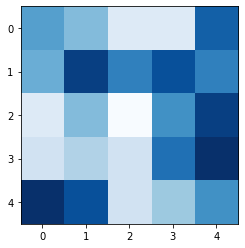

In [101]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)


Confusion matrix, without normalization
tf.Tensor(
[[15 13  8  8 19]
 [14 21 17 20 17]
 [ 8 13  6 16 21]
 [ 9 11  9 18 22]
 [22 20  9 12 16]], shape=(5, 5), dtype=int32)


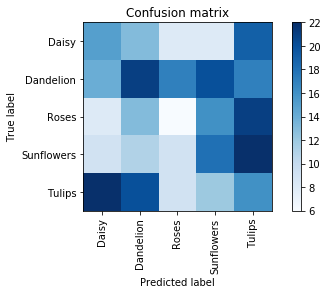

In [99]:
cm=tf.math.confusion_matrix(test_data.classes,pred_id )
plot_confusion_matrix(cm,class_names)

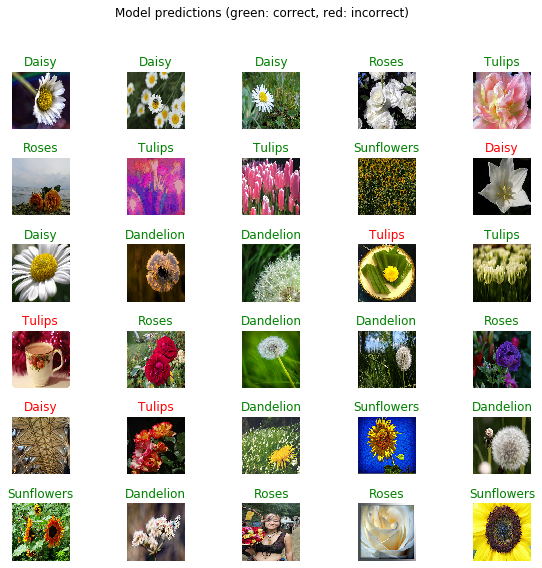

In [37]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## export model
这里是保留整个model！！！

In [ ]:
import os
abspath = os.path.abspath("")
print(abspath)
path = "/Users/allen/Desktop/tensorflow/model_saving"

In [ ]:
import time
t = time.time()

export_path = path+"/transfer learning"
tf.keras.experimental.export_saved_model(model, export_path)

export_path

In [ ]:
reloaded_model = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()